In [31]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV, train_test_split
import matplotlib.pyplot as plt

In [32]:
# Load the data
nl_df = pd.read_csv('/Users/jesselemeer/Documents/GitHub/Project2-2/Project_2-2/NL_data/train_set/processed_data.csv')

# Filter data for Amsterdam
ams_df = nl_df[(nl_df['latitude'] == 52.25) & (nl_df['longitude'] == 5.)]

# Sort values by time and set time as index
ams_df = ams_df.sort_values(by='time').set_index('time')

# Drop unnecessary columns
ams_df = ams_df.drop(['latitude', 'longitude', 'surface', 'step', 'number', 'valid_time','d2m'], axis=1)

# this just moves temp to the right of the DF, easier for X / y split
ams_df['temp'] = ams_df['t2m']
ams_df = ams_df.drop(['t2m'], axis = 1)

In [33]:
nl_df.head()

,time,latitude,longitude,surface,u10,v10,d2m,t2m,sp,tcc,...,month_7,month_8,month_9,month_10,month_11,month_12,hour_0,hour_6,hour_12,hour_18
0,2022-01-01 00:00:00,53.5,3.50,0.0,8.629013,4.519394,282.46686,283.44373,101881.06,0.964813,...,False,False,False,False,False,False,True,False,False,False
1,2022-01-01 00:00:00,53.5,3.75,0.0,8.801865,4.296738,282.50006,283.48083,101887.06,0.956665,...,False,False,False,False,False,False,True,False,False,False
2,2022-01-01 00:00:00,53.5,4.00,0.0,8.822372,4.069199,282.50397,283.51013,101897.06,0.951111,...,False,False,False,False,False,False,True,False,False,False
3,2022-01-01 00:00:00,53.5,4.25,0.0,8.698349,3.783066,282.50983,283.52966,101910.06,0.972260,...,False,False,False,False,False,False,True,False,False,False
4,2022-01-01 00:00:00,53.5,4.50,0.0,8.562607,3.510605,282.46490,283.48083,101917.06,0.997406,...,False,False,False,False,False,False,True,False,False,False


In [34]:
# Split the training and validation subsets
train_split = round(len(ams_df) * 0.8)
train_set = ams_df.iloc[:train_split, :]
valid_set = ams_df.iloc[train_split:, :]
print(train_set.shape)
print(valid_set.shape)



(16362, 21)
(4090, 21)


In [35]:
X_train, Y_train = train_set.iloc[:, :-1], train_set['temp']
X_valid, Y_valid = valid_set.iloc[:, :-1], valid_set['temp']

In [36]:
# Initialise and train the model
gbr = GradientBoostingRegressor()
gbr.fit(X_train, Y_train)

GradientBoostingRegressor()

In [37]:
# Make predictions using the model
Y_pred = gbr.predict(X_valid)

In [38]:
# Print first few predictions
print("Predictions:", Y_pred[:10])

# Print some test data
print("Data to compare:", X_valid[:10])

Predictions: [281.66051218 280.87003934 279.36843351 277.83923244 281.31649015
 280.19661293 277.67668725 278.71448614 281.47797318 280.29830426]
Data to compare:                           u10       v10          sp       tcc  month_1  \
time                                                                     
2021-03-14 12:00:00  6.363159 -1.733658  101057.190  0.621826    False   
2021-03-14 18:00:00  4.437119  0.130173  101170.060  0.873016    False   
2021-03-15 00:00:00  4.103958 -0.031998  100930.500  1.000000    False   
2021-03-15 06:00:00  3.605240 -2.830170  101106.750  0.366333    False   
2021-03-15 12:00:00  5.863617 -6.067627  101507.690  0.399567    False   
2021-03-15 18:00:00  4.335785 -5.503479  101895.560  0.273773    False   
2021-03-16 00:00:00  2.754562 -3.648849  102214.875  0.384827    False   
2021-03-16 06:00:00  2.927490 -2.659195  102368.310  0.997498    False   
2021-03-16 12:00:00  3.528137 -2.065109  102460.750  1.000000    False   
2021-03-16 18:00:00  1.

In [39]:
# Evaluate the model
mae = mean_absolute_error(Y_valid, Y_pred)
mse = mean_squared_error(Y_valid, Y_pred)
mape = mean_absolute_percentage_error(Y_valid, Y_pred)

print("Mean absolute error:", mae)
print("Mean squared error", mse)
print(f"Mean absolute percentage error: {mape} %")

Mean absolute error: 2.39868189013435
Mean squared error 9.39841572196618
Mean absolute percentage error: 0.008414640952354209 %


In [40]:
# Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, Y_train)

print("Best hyperparameters:", grid_search.best_params_)

Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}


In [41]:
# Now let's train a new model with the best hyperparameters
best_gbr = grid_search.best_estimator_
best_gbr.fit(X_train, Y_train)

GradientBoostingRegressor(max_depth=5, n_estimators=200)

In [42]:
best_Y_pred = best_gbr.predict(X_valid)

In [43]:
best_mae = mean_absolute_error(Y_valid, best_Y_pred)
best_mse = mean_squared_error(Y_valid, best_Y_pred)
best_mape = mean_absolute_percentage_error(Y_valid, best_Y_pred)

print("Best mean absolute error:", best_mae)
print("Best mean squared error:", best_mse)
print(f"Best mean absolute percentage error: {best_mape} %")

Best mean absolute error: 2.223642255068292
Best mean squared error: 7.9651966794504245
Best mean absolute percentage error: 0.007804872335377387 %


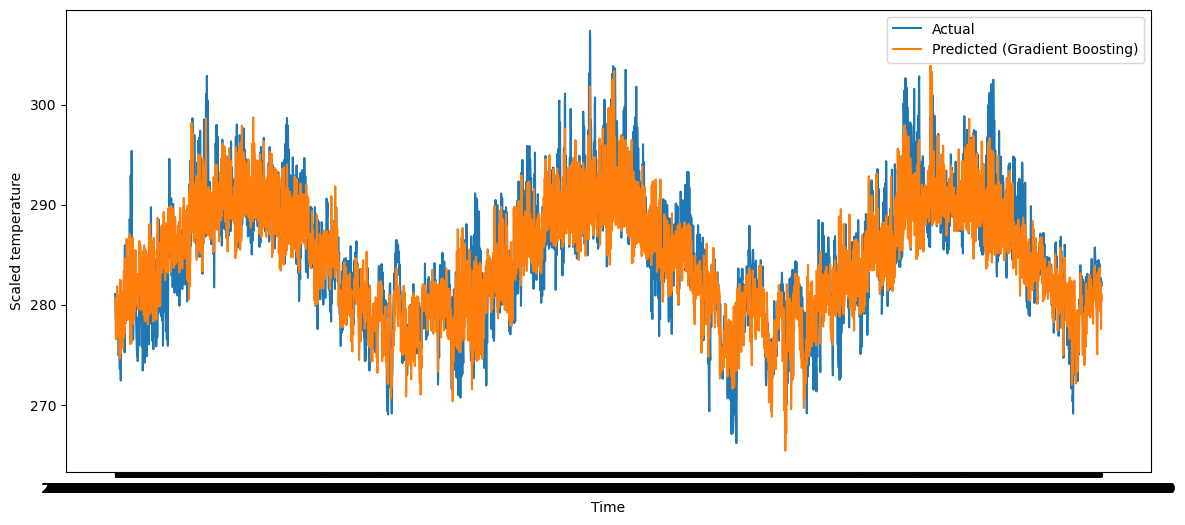

In [44]:
# Plotting the results
plt.figure(figsize=(14, 6))
plt.plot(Y_valid, label='Actual')
plt.plot(best_Y_pred, label='Predicted (Gradient Boosting)')
plt.xlabel('Time')
plt.ylabel('Scaled temperature') #in this case

plt.legend()
plt.show()

In [45]:
# Load the test data (2024)
nl_test_df = pd.read_csv('/Users/jesselemeer/Documents/GitHub/Project2-2/Project_2-2/NL_data/test_set/processed_data.csv')

# Filter data for Amsterdam
ams_test_df = nl_test_df[(nl_test_df['latitude'] == 52.25) & (nl_test_df['longitude'] == 5.)]

# Sort values by time and set time as index
ams_test_df = ams_test_df.sort_values(by='time').set_index('time')

# Drop unnecessary columns
ams_test_df = ams_test_df.drop(['latitude', 'longitude', 'surface', 'step', 'number', 'valid_time', 'd2m'], axis=1)

# Rename 't2m' column to 'temp'
# ams_df.rename(columns={'t2m': 'temp'}, inplace=True)

# this just moves temp to the right of the DF, easier for X / y split
ams_test_df['temp'] = ams_test_df['t2m']
ams_test_df = ams_test_df.drop(['t2m'], axis = 1)

In [46]:
#split into x and y
X_test, Y_test = ams_test_df.iloc[:, :-1], ams_test_df['temp']

In [47]:
best_Y_pred = best_gbr.predict(X_test)

In [48]:
best_mae = mean_absolute_error(Y_test, best_Y_pred)
best_mse = mean_squared_error(Y_test, best_Y_pred)
best_mape = mean_absolute_percentage_error(Y_test, best_Y_pred)

print("Best mean absolute error:", best_mae)
print("Best mean squared error:", best_mse)
print(f"Best mean absolute percentage error: {best_mape} %")

Best mean absolute error: 2.4005487622364887
Best mean squared error: 9.089961864943833
Best mean absolute percentage error: 0.008523945057517848 %


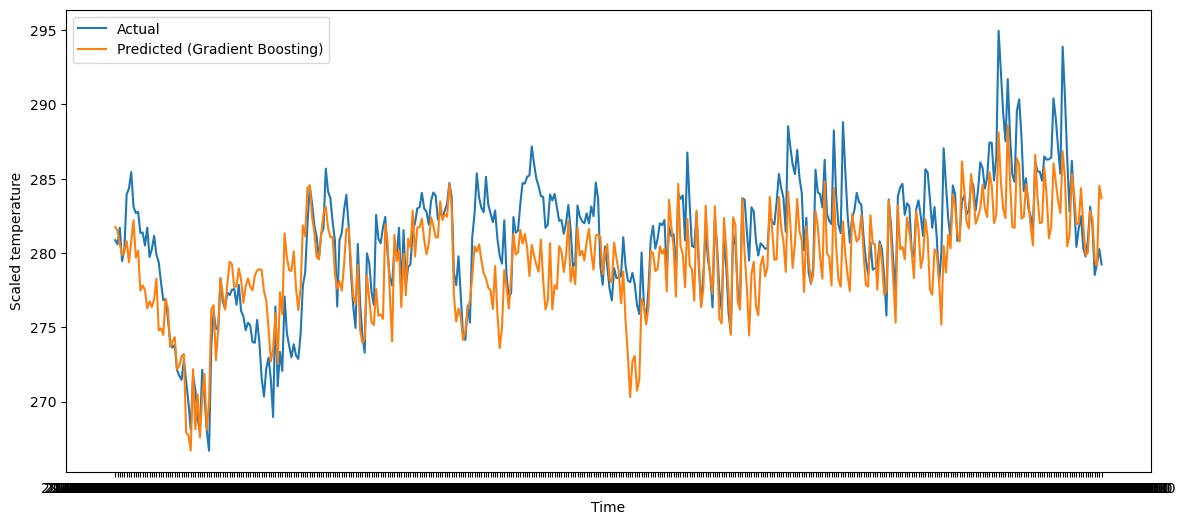

In [49]:
# Plotting the results
plt.figure(figsize=(14, 6))
plt.plot(Y_test, label='Actual')
plt.plot(best_Y_pred, label='Predicted (Gradient Boosting)')
plt.xlabel('Time')
plt.ylabel('Scaled temperature') #in this case

plt.legend()
plt.show()